In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt

In [ ]:
data=np.load('/content/drive/MyDrive/archive.zip')

In [ ]:
data.files

['fashion-mnist_test.csv',
 'fashion-mnist_train.csv',
 't10k-images-idx3-ubyte',
 't10k-labels-idx1-ubyte',
 'train-images-idx3-ubyte',
 'train-labels-idx1-ubyte']

In [ ]:
train_images=data['train-images-idx3-ubyte']
train_labels=data['train-labels-idx1-ubyte']

In [ ]:
test_images=data['t10k-images-idx3-ubyte']
test_labels=data['t10k-labels-idx1-ubyte']

In [ ]:
n_epochs = 100
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.05
momentum = 0.5
log_interval = 10

random_seed = 28
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('train_images', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('test_images', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,BatchNormalization
from keras import Sequential
from sklearn.model_selection import train_test_split
keras=tf.keras
from keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, Resizing, AveragePooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
 
# Print the dimensions of the dataset
print('Train: X = ', trainX.shape)
print('Test: X = ', testX.shape)

Train: X =  (60000, 28, 28)
Test: X =  (10000, 28, 28)


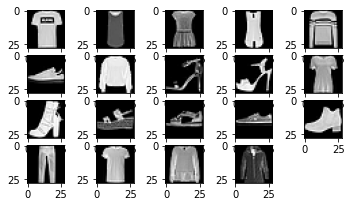

In [ ]:
for i in range(1, 20):
    # image in ith position of grid
    plt.subplot(5, 5, i)
    # Insert ith image with the color map 'grap'
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
 
# Display the entire plot
plt.show()

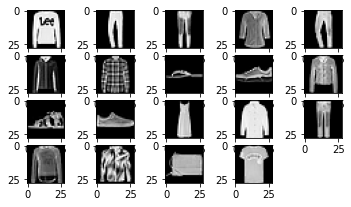

In [ ]:
for i in range(1, 20):
    # image in ith position of grid
    plt.subplot(5, 5, i)
    # Insert ith image with the color map 'grap'
    plt.imshow(testX[i], cmap=plt.get_cmap('gray'))
 
# Display the entire plot
plt.show()

# **BUILDING THE NETWORK**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

# **TRAINING THE MODEL**

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

# **EVALUATING** **THE MODEL'S** **PERFORMANCE**

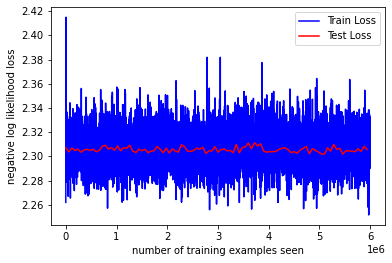

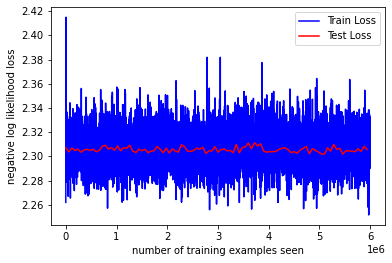

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig